# Fraud Transaction Detection


More information about the scikit learn API can be found:

- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- https://scikit-learn.org/dev/developers/contributing.html#rolling-your-own-estimator
- http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/

*If we are not able to run or replicate your code/steps, we will not grade your assessment.*

In [14]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support 

data = pd.read_csv('fraud_final_dataset.csv')

In [15]:
data.head()

,user_id,signup_time,purchase_time,elapsed_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,285108,7/15/2015 4:36,9/10/2015 14:17,2,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
1,131009,1/24/2015 12:29,4/13/2015 4:53,3,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
2,328855,3/11/2015 0:54,4/5/2015 12:23,1,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States
3,229053,1/7/2015 13:19,1/9/2015 10:12,0,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of
4,108439,2/8/2015 21:11,4/9/2015 14:26,2,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil


## EDA
A big portion of being a data scientist is his or her ability to understand the data. Please feel free to use the bottom cells to perform exploratory data analysis. Once you're done, please move on to the problems and tasks.

In [16]:
print("\nDescription of the Data : \n")
data.describe()


Description of the Data : 



,user_id,elapsed_time,purchase_value,age,ip_address,class
count,120000.000000,120000.000000,120000.000000,120000.000000,1.200000e+05,120000.000000
mean,200320.280100,1.860408,36.881475,33.125250,2.151550e+09,0.093875
std,115361.945935,1.250767,18.325855,8.617081,1.248314e+09,0.291656
min,2.000000,0.000000,9.000000,18.000000,9.344714e+04,0.000000
25%,100925.500000,1.000000,22.000000,27.000000,1.085345e+09,0.000000
50%,200037.500000,2.000000,34.000000,33.000000,2.155238e+09,0.000000
75%,300395.500000,3.000000,49.000000,39.000000,3.241268e+09,0.000000
max,400000.000000,4.000000,154.000000,76.000000,4.294850e+09,1.000000


**Note:**
As the Description of the data shows above, standard deviation of the data is normal from the mean(Except UserId and ip_address)

In [17]:
# Dataset shape & overview 
print(f"Shape of Data : {data.shape} \n")
print("Dataset Information: \n")
data.info()

Shape of Data : (120000, 13) 

Dataset Information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         120000 non-null  int64  
 1   signup_time     120000 non-null  object 
 2   purchase_time   120000 non-null  object 
 3   elapsed_time    120000 non-null  int64  
 4   purchase_value  120000 non-null  int64  
 5   device_id       120000 non-null  object 
 6   source          120000 non-null  object 
 7   browser         120000 non-null  object 
 8   sex             120000 non-null  object 
 9   age             120000 non-null  int64  
 10  ip_address      120000 non-null  float64
 11  class           120000 non-null  int64  
 12  country         120000 non-null  object 
dtypes: float64(1), int64(5), object(7)
memory usage: 11.9+ MB


**Note:**
As the Shape and Info shows above, we have no missing values so we don't need to worry about imputation


Distribution of the Target 'Class' : 


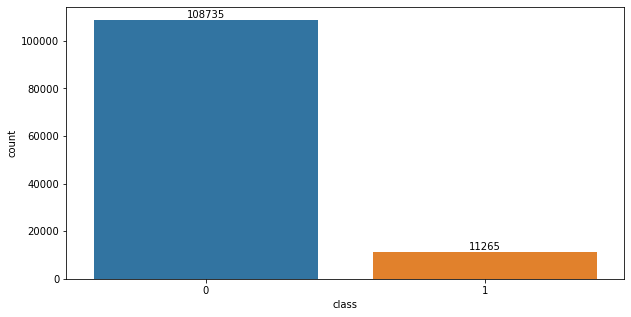

In [18]:
# Define a function to draw a bar chart of a specific feature in data
def count_plot(df, col):
    fig = plt.figure()
    ax = sns.countplot(x=df[col], order=df[col].value_counts().sort_index().index)
    abs_values = df[col].value_counts().sort_index()
    lbls = [f'{p[0]}' for p in zip(abs_values)]
    ax.bar_label(container=ax.containers[0], labels=lbls)

print("\nDistribution of the Target 'Class' : ")
count_plot(data, 'class')

**Takeaway:**

The target variable is imbalanced and the distribution is Approx 91% - 9%. It stays consistent with the fact that most fraudulent activities are much less frequenct than non-fraudulent. We shall take note of it before proceeding in order to avoid any overfitting issue when fitting the machine learning models.

Distribution of Categorical Features 'Sex', 'Source', 'Browser' : 


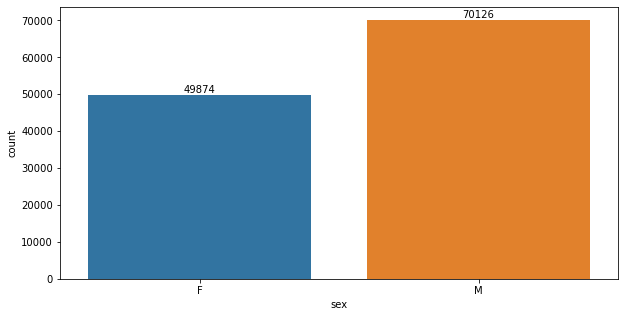

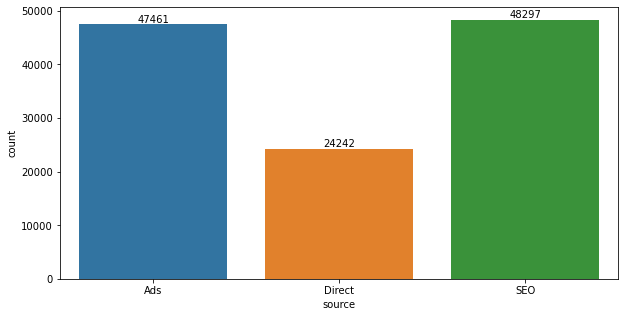

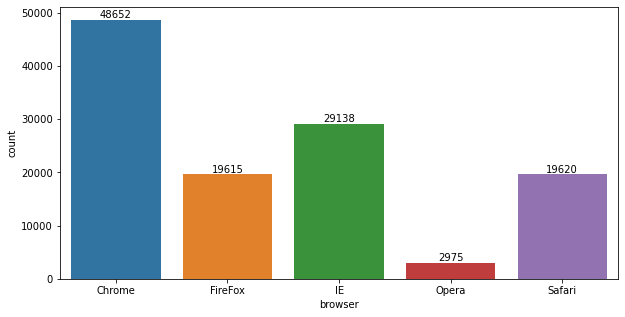

In [19]:
print("Distribution of Categorical Features 'Sex', 'Source', 'Browser' : ")
count_plot(data, 'sex')
count_plot(data, 'source')
count_plot(data, 'browser')

**Note :** Distribution of Sex, Source and Browser is approximately Uniform. Hence, they will be important features for Modeling

Distribution of Categorical Features with respect to Target : 


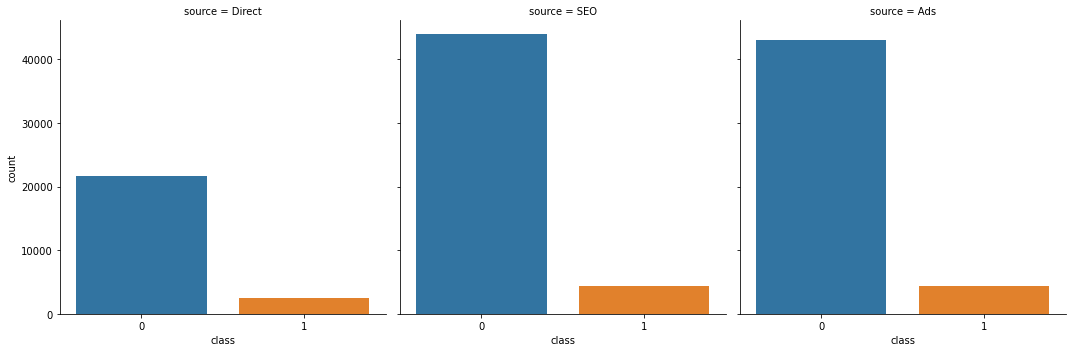

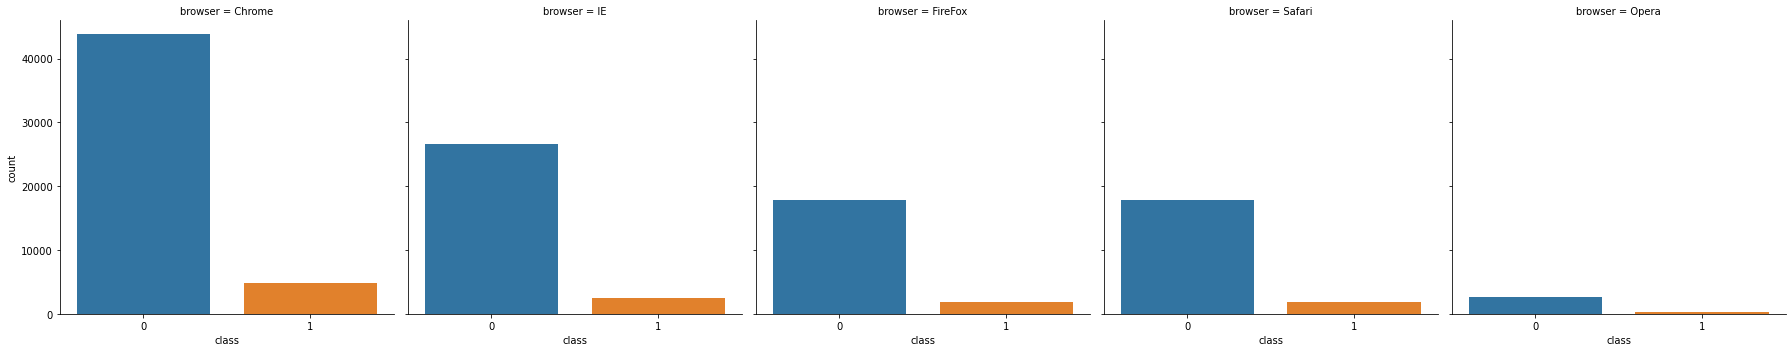

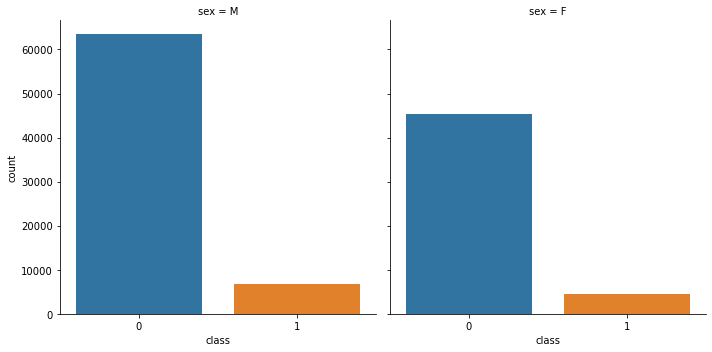

In [20]:
print("Distribution of Categorical Features with respect to Target : ")
sns.factorplot(x='class', col='source', kind='count', data=data)
sns.factorplot(x='class', col='browser', kind='count', data=data)
sns.factorplot(x='class', col='sex', kind='count', data=data)

The distribution of these features with respect to target is Approximately Uniform as well

Data Distribution of Target Variable 'Purchase Value' : 


<AxesSubplot:xlabel='purchase_value'>

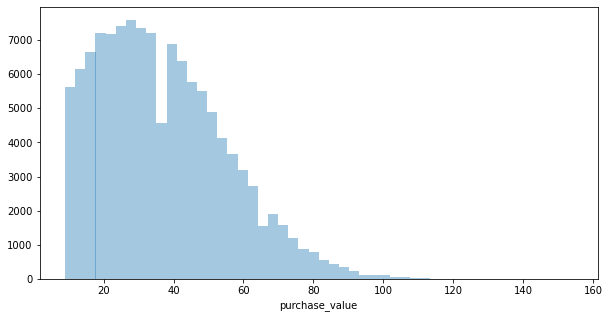

In [21]:
print("Data Distribution of Target Variable 'Purchase Value' : ")
sns.distplot(data.purchase_value, kde=False)

**Note :** There are no outlier Purchase Value in the transaction

Distribution of Purchase Time(0-23 hr) : 


<AxesSubplot:xlabel='purchase_time'>

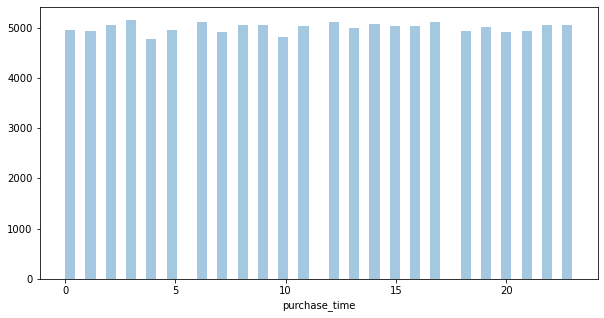

In [22]:
print("Distribution of Purchase Time(0-23 hr) : ")
out = data.purchase_time.apply(lambda x: int(x.split(' ')[1].split(':')[0])).sort_values(axis=0, ascending=True)
sns.distplot(out, kde=False)

**Note :** The number of transaction according to time is uniformly distributed across day. Now we can check the split of number of Fraud transaction by time

<AxesSubplot:title={'center':'Fraud non-Fraud composition by hour of purchase'}>

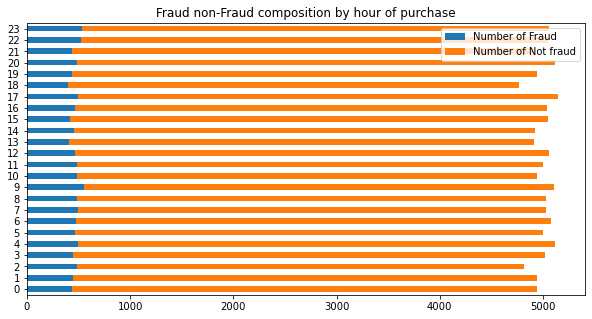

In [34]:
new_data = data.copy()
new_data['hour'] = new_data.purchase_time.apply(lambda x: int(x.split(' ')[1].split(':')[0])).sort_values(axis=0, ascending=True)

reason_cs = new_data['hour'].apply(lambda x: str(x)).str.get_dummies()
columns_x = reason_cs.columns
new_reason_df = pd.concat([reason_cs, new_data[['class']]], axis=1)

fraud = []
not_fraud = []
for col in columns_x:
    fraud.append(new_reason_df[(new_reason_df[col]==1) & (new_reason_df['class']== 1)][col].count())
    not_fraud.append(new_reason_df[(new_reason_df[col]==1) & (new_reason_df['class']== 0)][col].count())

# Create a sample dataframe
df = pd.DataFrame({'Number of Fraud': fraud,
                   'Number of Not fraud': not_fraud},
                  index=columns_x)
df.reset_index(inplace=True, drop=False)
df.sort_index(inplace=True)

plt.rcParams['figure.figsize'] = [10, 5]
# Plot stacked horizontal bar chart
df.plot.barh(stacked=True,
                     title="Fraud non-Fraud composition by hour of purchase")

**Note :** Number of Fraud transactions look uniformly distributed across time

## Feature Engineering

The steps we take below are, by no means, fully comprehensive nor production-level. However, we will assume that those steps below are **sufficient** for data processing and feature engineering in this assessment. 

### Problem 0 (provided - do NOT modify)
#### Write a custom transformer called CategoricalTransformer to encode categorical columns in an optional "columns" construction parameter.

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

### Problem 1
#### Write a custom transformer called DropColTransformer to drop the columns specified in an optional "columns" construction parameter.

In [36]:
class DropColTransformer(BaseEstimator, TransformerMixin):
    ### BEGIN SOLUTION
    def __init__(self,columns = None):
        self.columns = columns # array of column needs to be dropped

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        return X.drop(self.columns, axis=1)

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

### Problem 2
#### Write a custom transformer called FillMissingTransformer that fills in the missing values in the dataset that takes an optional "value" parameter that specifies what value to substitute for missing values.

In [37]:
class FillMissingTransformer(BaseEstimator, TransformerMixin):
    ### BEGIN SOLUTION
    def __init__(self, value = 99999):
        self.value = value

    def fit(self,X,y=None):
        return self

    def transform(self, X, y=None):
        output = X.copy()
        output = output.replace(np.nan, self.value)
        return output
        
    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

### Problem 3
#### Write a custom transformer called DateTransformer to cast date features into pandas datetime format that takes an optional construction parameter "columns" to specify which columns need to be transformed, and an optional parameter "strftime" that specifies the format to be parsed.

In [38]:
class DateTransformer(BaseEstimator, TransformerMixin):
    ### BEGIN SOLUTION
    def __init__(self, columns=None, strftime=None):
        self.columns = columns
        self.strftime = strftime
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = pd.to_datetime(output[col])
        return output
    
    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


### Problem 4 
#### Write a custom transformer called NumericalTransformer to: <br> 1) calculate the latency (i.e. time taken by the user in completing a transaction after registration)  <br> 2) calculate the number of users who are using the same device. 
The construction method need not contain an optional parameter.

In [39]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    ### BEGIN SOLUTION
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        output = X.copy()
        output['latency'] = output['purchase_time']-output['signup_time']
        output['latency'] = output['latency'].astype('timedelta64[h]')
        
        u, indices, counts = np.unique(output['device_id'], return_inverse=True, return_counts=True)
        output['device_users_count'] = counts[indices]
        return output
    
    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

### Problem 5 (provided - do NOT modify)
#### Create a Pipeline Object that concatonates all of the custom transformers that you have just created

In [40]:
from sklearn.pipeline import Pipeline
full_pipeline = Pipeline([
                        ('missing', FillMissingTransformer()),
                        ('dates', DateTransformer(['signup_time', 'purchase_time'])),
                        ('numerical', NumericalTransformer()),
                        ('categorical', CategoricalTransformer(['country', 'sex', 
                                                          'browser', 'source','device_id'])),
                        ('dropCat', DropColTransformer(['signup_time', 'purchase_time']))])

In [41]:
transformed_data = full_pipeline.fit_transform(data)

In [42]:
X = transformed_data.drop(['class'], axis = 1)
y = transformed_data['class']

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Modeling

Assuming this pipeline is sufficient for data processing and feature engineering, explore **how ever many** different model types and choose one model in which you'd like to move forward. Please explain why you would move forward with the best model.

**Preferably only use models from sklearn. If there is an absolute need to incorporate models from other packages, please specify which version of the package was used and explain why that package was needed.**

*Feel free to add/remove cells if needed*

**NOTE :** I have used package Xgboost for Modeling Extreme Gradient Boosting Algorithm, the version of this package is 1.5.2. Though we can use the full scikit-learn library with XGBoost models, but we need XGBClassifier package.

### Problem 6: Build model 1

#### Necessary steps to build the model

In [77]:
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knnclf=KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree', weights='distance')
knnclf.fit(X_train, y_train)

ypred_knn = knnclf.predict(X_test)

#### Performance metrics of interest & Validation results

**Note :** This is the imbalanced data, so we can not use the normal metric to evaluate. I have used Precision, Recall, f1-score and 'roc_auc' to evaluate the model

In [78]:
ypred_knn = knnclf.predict(X_test)
print('Confusion Matrix')
print(metrics.confusion_matrix(y_test, ypred_knn))
print('\nClassification Report')
print(metrics.classification_report(y_test, ypred_knn))
print("-----------------------------------------------------------------------------------------")
print('Accuracy : %f' % (metrics.accuracy_score(y_test, ypred_knn)))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, ypred_knn)))

Confusion Matrix
[[26189  1011]
 [ 1573  1227]]

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     27200
           1       0.55      0.44      0.49      2800

    accuracy                           0.91     30000
   macro avg       0.75      0.70      0.72     30000
weighted avg       0.91      0.91      0.91     30000

Accuracy : 0.913867
Area under the curve : 0.700523


-------------

###### We will use 10 fold KFold Cross Validation to train the model for improving the area under the curve score for the KNN classifier

In [92]:
# Evaluate every algorithms to find out the best one
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold=KFold(n_splits=10,shuffle=True, random_state=0)

knnclf=KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree', weights='distance')
score=cross_val_score(knnclf, X_train, y_train, cv=k_fold, n_jobs=1, scoring='roc_auc')

In [93]:
np.mean(score)
print('New Area under the curve : %f' % (np.mean(score)))

New Area under the curve : 0.746917


### Problem 7: Build model 2

#### Necessary steps to build the model

In [75]:
from sklearn.ensemble import RandomForestClassifier

rfclf = RandomForestClassifier()
rfclf.fit(X_train, y_train)

RandomForestClassifier()

#### Performance metrics of interest & Validation results

**Note :** This is the imbalanced data, so we can not use the normal metric to evaluate. I have used Precision, Recall, f1-score and 'roc_auc' to evaluate the model

In [76]:
ypred_rf = rfclf.predict(X_test)
print('Confusion Matrix')
print(metrics.confusion_matrix(y_test, ypred_rf))
print('\nClassification Report')
print(metrics.classification_report(y_test, ypred_rf))
print("-----------------------------------------------------------------------------------------")
print('Accuracy : %f' % (metrics.accuracy_score(y_test, ypred_rf)))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, ypred_rf)))

Confusion Matrix
[[27193     7]
 [ 1325  1475]]

Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27200
           1       1.00      0.53      0.69      2800

    accuracy                           0.96     30000
   macro avg       0.97      0.76      0.83     30000
weighted avg       0.96      0.96      0.95     30000

Accuracy : 0.955600
Area under the curve : 0.763264


------

###### We will use 10 fold KFold Cross Validation to train the model for improving the area under the curve score for the Random Forest classifier

In [94]:
# Evaluate every algorithms to find out the best one
rfclf=RandomForestClassifier()
score=cross_val_score(rfclf, X_train, y_train, cv=k_fold, n_jobs=1, scoring='roc_auc')

In [95]:
np.mean(score)
print('New Area under the curve : %f' % (np.mean(score)))

New Area under the curve : 0.829295


### Problem 8: Build model 3

#### Necessary steps to build the model

In [110]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [82]:
from xgboost.sklearn import XGBClassifier

xgb_model = XGBClassifier(learning_rate=0.05, max_depth=6, n_estimators=250)
xgb_model.fit(X_train, y_train, eval_metric=['error'], eval_set=[((X_train, y_train)),(X_test, y_test)])

[0]	validation_0-error:0.04307	validation_1-error:0.04483
[1]	validation_0-error:0.04309	validation_1-error:0.04483
[2]	validation_0-error:0.04310	validation_1-error:0.04477
[3]	validation_0-error:0.04310	validation_1-error:0.04477
[4]	validation_0-error:0.04310	validation_1-error:0.04477
[5]	validation_0-error:0.04310	validation_1-error:0.04477
[6]	validation_0-error:0.04310	validation_1-error:0.04477
[7]	validation_0-error:0.04310	validation_1-error:0.04477
[8]	validation_0-error:0.04307	validation_1-error:0.04480
[9]	validation_0-error:0.04306	validation_1-error:0.04477
[10]	validation_0-error:0.04304	validation_1-error:0.04477
[11]	validation_0-error:0.04302	validation_1-error:0.04477
[12]	validation_0-error:0.04302	validation_1-error:0.04477
[13]	validation_0-error:0.04302	validation_1-error:0.04477
[14]	validation_0-error:0.04304	validation_1-error:0.04477
[15]	validation_0-error:0.04304	validation_1-error:0.04477
[16]	validation_0-error:0.04304	validation_1-error:0.04477
[17]	va

[139]	validation_0-error:0.04309	validation_1-error:0.04453
[140]	validation_0-error:0.04309	validation_1-error:0.04450
[141]	validation_0-error:0.04309	validation_1-error:0.04450
[142]	validation_0-error:0.04309	validation_1-error:0.04450
[143]	validation_0-error:0.04309	validation_1-error:0.04450
[144]	validation_0-error:0.04309	validation_1-error:0.04450
[145]	validation_0-error:0.04309	validation_1-error:0.04450
[146]	validation_0-error:0.04309	validation_1-error:0.04450
[147]	validation_0-error:0.04309	validation_1-error:0.04450
[148]	validation_0-error:0.04309	validation_1-error:0.04450
[149]	validation_0-error:0.04309	validation_1-error:0.04450
[150]	validation_0-error:0.04309	validation_1-error:0.04450
[151]	validation_0-error:0.04309	validation_1-error:0.04453
[152]	validation_0-error:0.04309	validation_1-error:0.04453
[153]	validation_0-error:0.04309	validation_1-error:0.04453
[154]	validation_0-error:0.04310	validation_1-error:0.04453
[155]	validation_0-error:0.04310	validat

[276]	validation_0-error:0.04297	validation_1-error:0.04447
[277]	validation_0-error:0.04296	validation_1-error:0.04447
[278]	validation_0-error:0.04296	validation_1-error:0.04443
[279]	validation_0-error:0.04296	validation_1-error:0.04443
[280]	validation_0-error:0.04296	validation_1-error:0.04443
[281]	validation_0-error:0.04296	validation_1-error:0.04443
[282]	validation_0-error:0.04296	validation_1-error:0.04443
[283]	validation_0-error:0.04296	validation_1-error:0.04443
[284]	validation_0-error:0.04296	validation_1-error:0.04443
[285]	validation_0-error:0.04293	validation_1-error:0.04443
[286]	validation_0-error:0.04293	validation_1-error:0.04443
[287]	validation_0-error:0.04293	validation_1-error:0.04443
[288]	validation_0-error:0.04294	validation_1-error:0.04443
[289]	validation_0-error:0.04291	validation_1-error:0.04443
[290]	validation_0-error:0.04291	validation_1-error:0.04443
[291]	validation_0-error:0.04291	validation_1-error:0.04443
[292]	validation_0-error:0.04291	validat

[413]	validation_0-error:0.04273	validation_1-error:0.04447
[414]	validation_0-error:0.04273	validation_1-error:0.04447
[415]	validation_0-error:0.04272	validation_1-error:0.04447
[416]	validation_0-error:0.04272	validation_1-error:0.04450
[417]	validation_0-error:0.04272	validation_1-error:0.04453
[418]	validation_0-error:0.04272	validation_1-error:0.04453
[419]	validation_0-error:0.04272	validation_1-error:0.04453
[420]	validation_0-error:0.04271	validation_1-error:0.04453
[421]	validation_0-error:0.04271	validation_1-error:0.04453
[422]	validation_0-error:0.04271	validation_1-error:0.04453
[423]	validation_0-error:0.04270	validation_1-error:0.04453
[424]	validation_0-error:0.04270	validation_1-error:0.04453
[425]	validation_0-error:0.04268	validation_1-error:0.04457
[426]	validation_0-error:0.04269	validation_1-error:0.04460
[427]	validation_0-error:0.04269	validation_1-error:0.04457
[428]	validation_0-error:0.04269	validation_1-error:0.04457
[429]	validation_0-error:0.04269	validat

[550]	validation_0-error:0.04246	validation_1-error:0.04453
[551]	validation_0-error:0.04246	validation_1-error:0.04453
[552]	validation_0-error:0.04244	validation_1-error:0.04453
[553]	validation_0-error:0.04244	validation_1-error:0.04453
[554]	validation_0-error:0.04246	validation_1-error:0.04453
[555]	validation_0-error:0.04246	validation_1-error:0.04453
[556]	validation_0-error:0.04246	validation_1-error:0.04453
[557]	validation_0-error:0.04246	validation_1-error:0.04453
[558]	validation_0-error:0.04246	validation_1-error:0.04453
[559]	validation_0-error:0.04246	validation_1-error:0.04453
[560]	validation_0-error:0.04246	validation_1-error:0.04453
[561]	validation_0-error:0.04246	validation_1-error:0.04453
[562]	validation_0-error:0.04246	validation_1-error:0.04453
[563]	validation_0-error:0.04246	validation_1-error:0.04453
[564]	validation_0-error:0.04246	validation_1-error:0.04453
[565]	validation_0-error:0.04246	validation_1-error:0.04453
[566]	validation_0-error:0.04244	validat

[687]	validation_0-error:0.04233	validation_1-error:0.04453
[688]	validation_0-error:0.04234	validation_1-error:0.04453
[689]	validation_0-error:0.04234	validation_1-error:0.04453
[690]	validation_0-error:0.04234	validation_1-error:0.04453
[691]	validation_0-error:0.04234	validation_1-error:0.04453
[692]	validation_0-error:0.04234	validation_1-error:0.04453
[693]	validation_0-error:0.04234	validation_1-error:0.04453
[694]	validation_0-error:0.04234	validation_1-error:0.04453
[695]	validation_0-error:0.04234	validation_1-error:0.04453
[696]	validation_0-error:0.04234	validation_1-error:0.04453
[697]	validation_0-error:0.04234	validation_1-error:0.04453
[698]	validation_0-error:0.04234	validation_1-error:0.04453
[699]	validation_0-error:0.04234	validation_1-error:0.04453
[700]	validation_0-error:0.04234	validation_1-error:0.04453
[701]	validation_0-error:0.04233	validation_1-error:0.04453
[702]	validation_0-error:0.04233	validation_1-error:0.04453
[703]	validation_0-error:0.04233	validat

[824]	validation_0-error:0.04213	validation_1-error:0.04457
[825]	validation_0-error:0.04213	validation_1-error:0.04457
[826]	validation_0-error:0.04213	validation_1-error:0.04457
[827]	validation_0-error:0.04213	validation_1-error:0.04457
[828]	validation_0-error:0.04213	validation_1-error:0.04457
[829]	validation_0-error:0.04213	validation_1-error:0.04457
[830]	validation_0-error:0.04213	validation_1-error:0.04457
[831]	validation_0-error:0.04212	validation_1-error:0.04457
[832]	validation_0-error:0.04212	validation_1-error:0.04453
[833]	validation_0-error:0.04212	validation_1-error:0.04453
[834]	validation_0-error:0.04212	validation_1-error:0.04453
[835]	validation_0-error:0.04212	validation_1-error:0.04453
[836]	validation_0-error:0.04212	validation_1-error:0.04453
[837]	validation_0-error:0.04212	validation_1-error:0.04457
[838]	validation_0-error:0.04212	validation_1-error:0.04457
[839]	validation_0-error:0.04212	validation_1-error:0.04457
[840]	validation_0-error:0.04211	validat

[961]	validation_0-error:0.04197	validation_1-error:0.04460
[962]	validation_0-error:0.04196	validation_1-error:0.04463
[963]	validation_0-error:0.04196	validation_1-error:0.04463
[964]	validation_0-error:0.04196	validation_1-error:0.04463
[965]	validation_0-error:0.04194	validation_1-error:0.04463
[966]	validation_0-error:0.04193	validation_1-error:0.04463
[967]	validation_0-error:0.04193	validation_1-error:0.04463
[968]	validation_0-error:0.04193	validation_1-error:0.04460
[969]	validation_0-error:0.04193	validation_1-error:0.04460
[970]	validation_0-error:0.04193	validation_1-error:0.04460
[971]	validation_0-error:0.04193	validation_1-error:0.04460
[972]	validation_0-error:0.04192	validation_1-error:0.04460
[973]	validation_0-error:0.04192	validation_1-error:0.04460
[974]	validation_0-error:0.04192	validation_1-error:0.04460
[975]	validation_0-error:0.04192	validation_1-error:0.04460
[976]	validation_0-error:0.04192	validation_1-error:0.04460
[977]	validation_0-error:0.04192	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Performance metrics of interest & Validation results

**Note :** This is the imbalanced data, so we can not use the normal metric to evaluate. I have used Precision, Recall, f1-score and 'roc_auc' to evaluate the model

In [107]:
ypred_xgb = xgb_model.predict(X_test)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(y_test, ypred_xgb))
print('classification report')
print(metrics.classification_report(y_test, ypred_xgb))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(y_test, ypred_xgb))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, ypred_xgb)))

confusion matrix
[[27186    14]
 [ 1324  1476]]
classification report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27200
           1       0.99      0.53      0.69      2800

    accuracy                           0.96     30000
   macro avg       0.97      0.76      0.83     30000
weighted avg       0.96      0.96      0.95     30000

-----------------------------------------------------------------------------------------
Accuracy is :
0.9554
Area under the curve : 0.763314


--------

###### We will use 10 fold KFold Cross Validation to train the model for improving the area under the curve score for the Random Forest classifier

In [100]:
# Evaluate every algorithms to find out the best one
rfclf=RandomForestClassifier()
xgbclf = XGBClassifier(learning_rate=0.05, max_depth=6, n_estimators=250, eval_metric='logloss')
score=cross_val_score(xgbclf, X_train, y_train, cv=k_fold, n_jobs=1, scoring='roc_auc')

In [101]:
np.mean(score)
print('New Area under the curve : %f' % (np.mean(score)))

New Area under the curve : 0.830470


**Note :** ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds

### Problem 9: Explain why you chose your model to move forward

In [55]:
print("""
I chose XGBoost Model because:
1. The model performance metrics is better than other Classifiers after modeling on KFold Cross Validation
2. It performs well because data was mixture numerical and categorical features
3. XGBoost has in-built L1 and L2 regularization which prevents the model from overfitting
4. Thus, this algorithm delivers high performance as compared to other algorithms
""")


I chose XGBoost Model because:
1. The model performance metrics is better than other Classifiers
2. It performed well because data was mixture numerical and categorical features
3. XGBoost has in-built L1 and L2 regularization which prevents the model from overfitting
4. Thus, this algorithm delivers high performance and accuracy as compared to other algorithms



### Problem 10: Next Steps
Open-ended Question: What would you do to improve this model in data processing steps, feature engineering steps, and/or modeling stage? 

In [111]:
print("""
Data Processing steps - The target is Imbalanced, below are the few steps in data wrangling which would improve this model :
1) The more Fraudulent data for unseen variables and cases will help the model to perform better
1) With same data, I would perform Oversampling (such as Random or SMOTE), for minority target variable
2) Undersampling (such as Random, NearMiss or Undersampling with clustering) on the majority target variable can also be performed to improve efficiency

Feature Engineering:
1. I will find the Geo location using ipaddress and use this feature for modeling because there can be relation between this feature and target
2. Remove features which are not important such as UserId and ipaddress

Modeling:
1. We can see an increase in AUC score. High AUC increases the chance that we will be able to find an optimal threshold that will satisfy these requirements. It can be further optimized by performing Hyperparameter Tuning
2. Next step would be to learn the bias parameter and fine-tuning the model by using a standard optimization metric

""")


Data Processing steps - The target is Imbalanced, below are the few steps in data wrangling which would improve this model :
1) The more Fraudulent data for unseen variables and cases will help the model to perform better
1) With same data, I would perform Oversampling (such as Random or SMOTE), for minority target variable
2) Undersampling (such as Random, NearMiss or Undersampling with clustering) on the majority target variable can also be performed to improve efficiency

Feature Engineering:
1. I will find the Geo location using ipaddress and use this feature for modeling because there can be relation between this feature and target
2. Remove features such as UserId and ipaddress because they are not important features

Modeling:
1. We can see an increase in AUC score. High AUC increases the chance that we will be able to find an optimal threshold that will satisfy these requirements. It can be further increased by performing Hyperparameter Tuning
2. We need to do random sampling 